In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy   as np
import sklearn as skl

import matplotlib.pyplot as plt
import seaborn           as srn

from sklearn.model_selection       import train_test_split
from sklearn.svm                   import OneClassSVM
from sklearn.kernel_approximation  import Nystroem
from sklearn.neighbors             import KernelDensity
from sklearn.model_selection       import GridSearchCV
from sklearn.metrics               import pairwise_distances
from scipy.stats                   import beta
import random
import numpy as np
import random
import numpy as np
import seaborn as sns, numpy as np
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import sys
from sklearn import svm
import time
import tensorflow as tf
from sklearn.metrics import precision_score,accuracy_score
import csv
from itertools import izip_longest

Generate samples from a Beta(2, 2) distribution.

In [2]:
np.random.seed(42)
N = 10**4

X     = beta.rvs(a = 2, b = 2, size = N)[:,np.newaxis]
pStar = lambda x: beta.pdf(x, a = 2, b = 2)

XTr, XTe = train_test_split(X, train_size = 0.80, test_size = 0.20, random_state = 42)
XTe      = XTe[np.argsort(XTe.flatten()),:]

In [5]:
# results = "/Users/raghav/Documents/Uni/NIPS-2018/experiments/sanity_results/"
# decision_scorePath = "/Users/raghav/Documents/Uni/NIPS-2018/experiments/scores/"
# df_usps_scores  = {}
# activations = ["Linear","Sigmoid"]
# methods = ["Linear","RBF"]
# path = "/Users/raghav/Documents/Uni/NIPS-2018/experiments/scores/"

results = "./sanity_results/"
decision_scorePath = "/Users/raghav/Documents/Uni/NIPS-2018/experiments/scores/"
df_usps_scores  = {}
activations = ["Linear","Sigmoid"]
methods = ["Linear","RBF"]
path = "/Users/raghav/Documents/Uni/NIPS-2018/experiments/scores/"
outfile = "/Users/raghav/Documents/Uni/NIPS-2018/experiments/sanity_beta_distribution/weights/"
nu = 0.1

def write_Scores2Csv(train, trainscore, test, testscore,filename):

    data = np.concatenate((train, test))
    score= np.concatenate((trainscore,testscore))
    data = data.tolist()
    score = score.tolist()
    with open(filename, 'a') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(("x", "score"))
    for row in range(0,len(data)):
        with open(filename,
                  'a') as myfile:
            wr = csv.writer(myfile)

            wr.writerow((" ".join(str(x) for x in data[row]), " ".join(str(x) for x in score[row])))


def write_decisionScores2Csv(path, filename, positiveScores, negativeScores):

    newfilePath = path+filename
    print "Writing file to ", path+filename
    poslist = positiveScores.tolist()
    neglist = negativeScores.tolist()

    # rows = zip(poslist, neglist)
    d = [poslist, neglist]
    export_data = izip_longest(*d, fillvalue='')
    with open(newfilePath, 'w') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(("Normal", "Anomaly"))
        wr.writerows(export_data)
    myfile.close()

    return


def tf_OneClass_NN_sigmoid(data_train,data_test):

    tf.reset_default_graph()

    train_X = data_train

    RANDOM_SEED = 42
    tf.set_random_seed(RANDOM_SEED)

     # Layer's sizes
    x_size = train_X.shape[1]   # Number of input nodes: 4 features and 1 bias
    h_size = 200                # Number of hidden nodes
    y_size = 1   # Number of outcomes (3 iris flowers)
    D = x_size
    K = h_size

    theta = np.random.normal(0, 1, K + K*D + 1)
    rvalue = np.random.normal(0,1,(len(train_X),y_size))
  

    def init_weights(shape):
        """ Weight initialization """
        weights = tf.random_normal(shape,mean=0, stddev=0.5)
        return tf.Variable(weights,trainable=False)

    def forwardprop(X, w_1, w_2):
        """
        Forward-propagation.
        IMPORTANT: yhat is not softmax since TensorFlow's softmax_cross_entropy_with_logits() does that internally.
        """
        X = tf.cast(X, tf.float32)
        w_1 = tf.cast(w_1, tf.float32)
        w_2 = tf.cast(w_2, tf.float32)
        h    = tf.nn.sigmoid(tf.matmul(X, w_1))  # The \sigma function
        yhat = tf.matmul(h, w_2)  # The \varphi function
        return yhat

#     g   = lambda x : 1/(1 + tf.exp(-x))
#     g   = lambda x : tf.nn.sigmoid(x)
    g   = lambda x : (1/np.sqrt(h_size) )*tf.cos(x/0.02)

    def nnScore(X, w, V, g,bias1,bias2):
        X = tf.cast(X, tf.float32)
        w = tf.cast(w, tf.float32)
        V = tf.cast(V, tf.float32)
        y_hat =tf.matmul(g((tf.matmul(X, w)+bias1)), V) +bias2
#         return tf.matmul(g((tf.matmul(X, w))), V)
        return y_hat

    def relu(x):
        y = x
        y[y < 0] = 0
        return y
    
    
       # For testing the algorithm
    def compute_LossValue(X, nu, w1, w2, g, r,bias1,bias2):
        w = w1
        V = w2

        X = tf.cast(X, tf.float32)
        w = tf.cast(w1, tf.float32)
        V = tf.cast(w2, tf.float32)
        term1 = 0.5 * tf.reduce_sum(tf.square(w))
        term2 = 0.5 * tf.reduce_sum(tf.square(V))


#         term3 = 1 / nu * tf.reduce_mean(tf.maximum(0.0, r - nnScore(X, w, V, g,bias1,bias2)))
       
        term3 = 1 / nu * tf.reduce_mean(tf.nn.relu(r - nnScore(X, w, V, g,bias1,bias2)))
        term4 = -r
     
        y_hat = nnScore(X, w, V, g,bias1,bias2)
    
        totalCost = term1 + term2 + term3 + term4
        
        loss=   [term1,term2,term3,term4,totalCost,y_hat]
        return loss
    
    
    def ocnn_obj(theta, X, nu, w1, w2, g,r,bias1,bias2):

        w = w1
        V = w2


        X = tf.cast(X, tf.float32)
        w = tf.cast(w1, tf.float32)
        V = tf.cast(w2, tf.float32)


        term1 = 0.5  * tf.reduce_sum(w**2)
        term2 = 0.5  * tf.reduce_sum(V**2)
        term3 = 1/nu * tf.reduce_mean(tf.nn.relu(r - nnScore(X, w, V, g,bias1,bias2)))
        term4 = -r

        return term1 + term2 + term3 + term4


    # For testing the algorithm
    test_X = data_test


    # Symbols
    X = tf.placeholder("float32", shape=[None, x_size])

    r = tf.get_variable("r", dtype=tf.float32,shape=(),trainable=False)

    # Weight initializations
    w_1 = init_weights((x_size, h_size))
    #     w_2 = init_weights((h_size, y_size))
    weights = tf.random_normal((h_size, y_size),mean=0, stddev=0.1)
#     w_2 =  tf.Variable(weights)
    ocsvm_wt = np.load(outfile+"ocsvm_wt.npy")
    w_2 =tf.get_variable("tf_var_initialized_ocsvm",
                                 initializer=ocsvm_wt)
    
    bias1 = tf.Variable(initial_value=[[1.0]], dtype=tf.float32,trainable=False)
    bias2 = tf.Variable(initial_value=[[0.0]], dtype=tf.float32,trainable=False)

    # Forward propagation
    yhat    = forwardprop(X, w_1, w_2)
    predict = tf.argmax(yhat, axis=1)


    # Backward propagation
    # cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
    cost    = ocnn_obj(theta, X, nu, w_1, w_2, g,r,bias1,bias2)
#     updates = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)
    updates = tf.train.AdamOptimizer(4.7 * 1e-1).minimize(cost)

    # Run SGD
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    rvalue = 0.1
    start_time = time.time()
    for epoch in range(100):
            # Train with each example
                sess.run(updates, feed_dict={X: train_X, r:rvalue})
                
               
                with sess.as_default():
                    svalue = nnScore(train_X, w_1, w_2, g,bias1,bias2)  
                    print "Checking svalue <rvalue: ",np.mean(svalue.eval() < rvalue)
                    rval = svalue.eval()
                    rvalue = np.percentile(rval,q=100*nu)
                    
                    print "Checking svalue <rvalue: ",np.mean(svalue.eval() < rvalue)
                    costvalue = compute_LossValue(train_X, nu, w_1, w_2, g, rvalue,bias1,bias2)
                    term1 = costvalue[0].eval()
                    term2 = costvalue[1].eval()
                    term3 = costvalue[2].eval()
                    term4 = costvalue[3]
                    term5 = costvalue[4].eval()
                    yval = costvalue[5].eval()
  
                print("Epoch = %d, r = %f"
                  % (epoch + 1,rvalue))
                print ("Cost:(term1,term2,term3,term4,term5,yhat) ", np.mean(term1),np.mean(term2),(term3),np.mean(term4),np.mean(term5),np.mean(yval))
                print ("Total Cost: ",np.mean(term5))
                
                with sess.as_default():
                    print "Checking svalue <rvalue: ",np.mean(svalue.eval() < rvalue)
                print "================================"
                print "================================"

    trainTime = time.time() - start_time

    start_time = time.time()
    train = nnScore(train_X, w_1, w_2, g,bias1,bias2)
    test = nnScore(test_X, w_1, w_2, g,bias1,bias2)
    testTime = time.time() - start_time
    with sess.as_default():
        np_w_1= w_1.eval()
        np_w_2= w_2.eval()
        np_bias1= bias1.eval()
        arrayTrain = train.eval()
        arrayTest = test.eval()
    #     rstar = r.eval()

    rstar =rvalue
    sess.close()
    print "Session Closed!!!"


#     pos_decisionScore = arrayTrain-rstar
#     neg_decisionScore = arrayTest-rstar
    pos_decisionScore = arrayTrain
    neg_decisionScore = arrayTest
    # save the w_1 and bias1 to numpy array
    np.save(outfile+"w_1", np_w_1)
    np.save(outfile+"w_2", np_w_2)
    np.save(outfile+"bias1",np_bias1)

    write_Scores2Csv(train_X,pos_decisionScore,test_X,neg_decisionScore,path+"OC_NN.csv")

    write_decisionScores2Csv(decision_scorePath,"Synthetic_OC-NN_Sigmoid.csv",pos_decisionScore,neg_decisionScore)


    return [pos_decisionScore, neg_decisionScore,trainTime,testTime,rstar]


### Call OC-NN Sigmoid 

In [6]:
[train_decisionScore, test_decisionScore,trainTime,testTime,rstar_OCNN] = tf_OneClass_NN_sigmoid(XTr,XTe)

Checking svalue <rvalue:  0.344375
Checking svalue <rvalue:  0.1
Epoch = 1, r = -242.032318
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 18802720.0, 125.59665, 242.03231811523438, 18803114.0, 120.02014)
('Total Cost: ', 18803114.0)
Checking svalue <rvalue:  0.1
Checking svalue <rvalue:  0.098875
Checking svalue <rvalue:  0.1
Epoch = 2, r = -241.788826
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 18762540.0, 125.48985, 241.78882598876953, 18762934.0, 119.88605)
('Total Cost: ', 18762934.0)
Checking svalue <rvalue:  0.1
Checking svalue <rvalue:  0.098875
Checking svalue <rvalue:  0.1
Epoch = 3, r = -241.545403
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 18722406.0, 125.383, 241.54540252685547, 18722800.0, 119.75197)
('Total Cost: ', 18722800.0)
Checking svalue <rvalue:  0.1
Checking svalue <rvalue:  0.098875
Checking svalue <rvalue:  0.1
Epoch = 4, r = -241.302121
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 18682318.0, 125.27603, 241.

Epoch = 25, r = -236.163637
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 17852516.0, 123.07793, 236.16363677978515, 17852902.0, 116.8084)
('Total Cost: ', 17852902.0)
Checking svalue <rvalue:  0.1
Checking svalue <rvalue:  0.099125
Checking svalue <rvalue:  0.1
Epoch = 26, r = -235.918126
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 17813622.0, 122.97531, 235.91812591552736, 17814006.0, 116.67508)
('Total Cost: ', 17814006.0)
Checking svalue <rvalue:  0.1
Checking svalue <rvalue:  0.099125
Checking svalue <rvalue:  0.1
Epoch = 27, r = -235.672630
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 17774788.0, 122.87278, 235.67263031005859, 17775172.0, 116.54182)
('Total Cost: ', 17775172.0)
Checking svalue <rvalue:  0.1
Checking svalue <rvalue:  0.099125
Checking svalue <rvalue:  0.1
Epoch = 28, r = -235.427303
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 17736012.0, 122.77028, 235.42730255126955, 17736396.0, 116.40862)
('Total Cost: ', 1773

Checking svalue <rvalue:  0.0995
Checking svalue <rvalue:  0.1
Epoch = 50, r = -230.177122
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 16898576.0, 120.40915, 230.1771224975586, 16898952.0, 113.49441)
('Total Cost: ', 16898952.0)
Checking svalue <rvalue:  0.1
Checking svalue <rvalue:  0.099625
Checking svalue <rvalue:  0.1
Epoch = 51, r = -229.937590
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 16861232.0, 120.30475, 229.93759002685547, 16861608.0, 113.36273)
('Total Cost: ', 16861608.0)
Checking svalue <rvalue:  0.1
Checking svalue <rvalue:  0.099625
Checking svalue <rvalue:  0.1
Epoch = 52, r = -229.698193
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 16823948.0, 120.20042, 229.69819335937501, 16824324.0, 113.23113)
('Total Cost: ', 16824324.0)
Checking svalue <rvalue:  0.1
Checking svalue <rvalue:  0.09975
Checking svalue <rvalue:  0.1
Epoch = 53, r = -229.459816
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 16786732.0, 120.09523, 22

Epoch = 74, r = -224.660634
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 16019631.0, 117.72537, 224.66063385009767, 16020000.0, 110.35472)
('Total Cost: ', 16020000.0)
Checking svalue <rvalue:  0.1
Checking svalue <rvalue:  0.09975
Checking svalue <rvalue:  0.1
Epoch = 75, r = -224.416924
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 15983791.0, 117.62971, 224.41692352294919, 15984159.0, 110.22485)
('Total Cost: ', 15984159.0)
Checking svalue <rvalue:  0.1
Checking svalue <rvalue:  0.09975
Checking svalue <rvalue:  0.1
Epoch = 76, r = -224.173302
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 15948012.0, 117.53416, 224.17330169677734, 15948380.0, 110.09502)
('Total Cost: ', 15948380.0)
Checking svalue <rvalue:  0.1
Checking svalue <rvalue:  0.09975
Checking svalue <rvalue:  0.1
Epoch = 77, r = -223.929834
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 15912293.0, 117.43859, 223.92983398437499, 15912660.0, 109.96529)
('Total Cost: ', 159126

Epoch = 99, r = -218.845850
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 15142078.0, 115.11139, 218.84584960937494, 15142438.0, 107.13032)
('Total Cost: ', 15142438.0)
Checking svalue <rvalue:  0.1
Checking svalue <rvalue:  0.1
Checking svalue <rvalue:  0.1
Epoch = 100, r = -218.641394
('Cost:(term1,term2,term3,term4,term5,yhat) ', 26.340065, 15107771.0, 114.98109, 218.64139404296873, 15108131.0, 107.00233)
('Total Cost: ', 15108131.0)
Checking svalue <rvalue:  0.1
Session Closed!!!
Writing file to  /Users/raghav/Documents/Uni/NIPS-2018/experiments/scores/Synthetic_OC-NN_Sigmoid.csv


In [7]:
print rstar_OCNN

-218.641394043


Plot the true density, the 10% quantile threshold for the density, and the OC-SVM predictions.

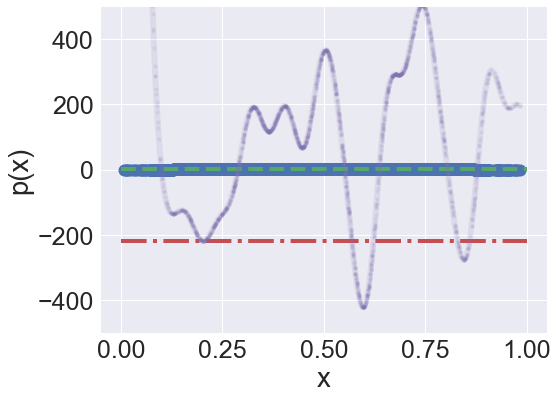

In [12]:
srn.set(font_scale = 2.5);
plt.figure(figsize = (8,6));

rStar = np.percentile(pStar(XTe), q = 100 * 0.10)

plt.plot(XTe, pStar(XTe),                        '.-', linewidth=8, markersize=24);
plt.plot([0,1], [rStar,rStar],                   '--', linewidth=4, markersize=24);
plt.plot([0,1], [rstar_OCNN,rstar_OCNN],         '-.', linewidth=4, markersize=24); # Optimal r value
plt.plot(XTe, test_decisionScore,      '.-', linewidth=6, markersize=8, alpha=0.125); # decision score
plt.ylim((-500, 500))
plt.xlabel('x'); plt.ylabel('p(x)');
plt.savefig('beta_test.pdf', bbox_inches = 'tight');